In [1]:
in_funds = ['VFINX', 'PRIDX']
out_funds = 'VUSTX'
benchmark = 'VFINX'

In [2]:
import yfinance as yf

# Download historical data
data = {}
all_funds = in_funds + [out_funds]
for symbol in all_funds:
    print(symbol)
    yf_ticker = yf.Ticker(symbol)
    yf_data = yf_ticker.history(period='max')
    data[symbol] = yf_data
    
benchmark = yf.Ticker(benchmark).history(period='max')

VFINX
PRIDX
VUSTX


In [3]:
# Select only month-end prices
monthend = {}
for symbol, df in data.items():
    day1 = list(df.index.month)
    day2 = list(df.index.month)
    day2.pop(0)
    day2.append(-1)
    days = zip(day1, day2)
    truth_vals = [False if x[0] == x[1] else True for x in days]
    df_month_end = df[truth_vals].copy()
    monthend[symbol] = df_month_end

In [4]:
# Calculate momentum signals
import numpy

# 1-month momentum
for symbol, df in monthend.items():
    close = numpy.array(df['Close'])
    momentum1 = (((close[1:]/close[:-1])-1)*100)
    momentum1 = numpy.insert(momentum1, 0, 0)
    df['Momentum1'] = momentum1

# 3-month momentum
for symbol, df in monthend.items():
    close = numpy.array(df['Close'])
    momentum3 = (((close[3:]/close[:-3])-1)*100)
    momentum3 = numpy.insert(momentum3, 0, [0, 0, 0])
    df['Momentum3'] = momentum3

# 6-month momentum
for symbol, df in monthend.items():
    close = numpy.array(df['Close'])
    momentum6 = (((close[6:]/close[:-6])-1)*100)
    momentum6 = numpy.insert(momentum6, 0, [0, 0, 0, 0, 0, 0])
    df['Momentum6'] = momentum6

# ADM Signal
for symbol, df in monthend.items():
    momentums = numpy.array((df['Momentum1'], df['Momentum3'], df['Momentum6']))
    df['ADMSignal'] = numpy.average(momentums, axis=0)

In [5]:
# Align time-axis for all symbols
import pandas
merged = None
for symbol, df in monthend.items():
    if not symbol in in_funds:
        continue
    if merged is None:
        merged = pandas.DataFrame(df['ADMSignal'])
        merged[f'{symbol}-ADMSignal'] = merged['ADMSignal']
        merged = merged.drop(columns=['ADMSignal'])
    else:
        df2 = pandas.DataFrame(df['ADMSignal'])
        df2[f'{symbol}-ADMSignal'] = df2['ADMSignal']
        df2 = df2.drop(columns=['ADMSignal'])
        merged = merged.merge(df2, how='inner', on='Date')
time_aligned = merged
print(time_aligned)

            VFINX-ADMSignal  PRIDX-ADMSignal
Date                                        
1988-12-30         2.696485         0.000000
1989-01-31         8.745183         1.393035
1989-02-28         5.477646         0.095511
1989-03-31         6.517398         1.297797
1989-04-28         7.655554         2.483286
...                     ...              ...
2020-03-31       -14.820500       -16.504324
2020-04-30         0.075828         0.524241
2020-05-29         2.025616         6.813656
2020-06-30         6.426191        13.170344
2020-07-09         2.969327         9.995524

[380 rows x 2 columns]


In [6]:
# Build portfolio
symbols = pandas.DataFrame(time_aligned.idxmax(axis=1), columns=['Symbol'])
symbols['Symbol'] = [x.split('-')[0] for x in symbols['Symbol']]
signal  = pandas.DataFrame(time_aligned.max(axis=1), columns=['Signal'])
in_signal = symbols.merge(signal, how='inner', on='Date')
for idx in in_signal[in_signal['Signal'] < 1].index:
    in_signal.loc[idx, 'Symbol'] = out_funds
portfolio = in_signal

In [12]:
# Compute portfolio returns & growth of 10k
current_asset = None
cash = 10000
qty = 0
for date in portfolio.index:
    new_asset = portfolio.loc[date]['Symbol']
    if current_asset is not None:
        # sell the current asset
        new_cash = monthend[current_asset].loc[date]['Close'] * qty
        qty = 0
        monthly_return = new_cash / cash - 1
        cash = new_cash
    else:
        monthly_return = 0.0
    current_asset = new_asset
    qty = cash / monthend[new_asset].loc[date]['Close']
    portfolio.loc[date, 'MonthlyReturn'] = monthly_return
    portfolio.loc[date, 'Value'] = cash
    portfolio.loc[date, 'Quantity'] = qty
    portfolio.loc[date, 'Price'] = monthend[new_asset].loc[date]['Close']

In [8]:
#  Compute daily returns for portfolio
returns = []

# Step 1 get all trading days for the period that the portfolio is active
start_date = list(portfolio.index)[0]
end_date = list(portfolio.index)[-1]
trading_days = []
for symbol, df in data.items():
    if start_date in list(df.index):
        for dt in list(df.index):
            if dt >= start_date and dt <= end_date:
                trading_days.append(dt)
        break

# Step 2 for each trading day compute portfolio return
last = start_date
asset = portfolio.loc[last]['Symbol']
for day in trading_days[1:]:
    current_close = data[asset].loc[day]['Close']
    previous_close = data[asset].loc[last]['Close']
    ret = current_close / previous_close - 1
    returns.append({'Date': day, 'Return': ret})

    # check if asset was sold
    if day in list(portfolio.index):
        asset = portfolio.loc[day]['Symbol']
    
    # update the last trading day
    last = day

returns_df = pandas.DataFrame([x['Return'] for x in returns], index=pandas.DatetimeIndex([x['Date'] for x in returns], name='Date'), columns=['Returns'])

In [13]:
# Print out last few items, to show what should be purchased
portfolio.tail()

,Symbol,Signal,MonthlyReturn,Value,Quantity,Price
Date,,,,,,
2020-03-31,VUSTX,-14.820500,0.057026,2.570402e+06,165086.864792,15.57
2020-04-30,VUSTX,0.524241,0.017983,2.616627e+06,165086.864792,15.85
2020-05-29,PRIDX,6.813656,-0.016404,2.573704e+06,37804.116071,68.08
2020-06-30,PRIDX,13.170344,0.042303,2.682580e+06,37804.116071,70.96
2020-07-09,PRIDX,9.995524,0.028467,2.758944e+06,37804.116071,72.98


In [10]:
# Compute benchmark returns
close = numpy.array(benchmark['Close'])
rets = (close[1:]/close[:-1]) - 1
rets = numpy.insert(rets, 0, 0)
benchmark['Returns'] = rets
benchmark_aligned = benchmark[benchmark.index > start_date]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,1989-01-03
End date,2020-07-09
Total months,378
,Backtest
Annual return,19.521%
Cumulative returns,27489.444%
Annual volatility,13.466%
Sharpe ratio,1.39
Calmar ratio,0.65
Stability,0.98
Max drawdown,-30.212%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.21,2000-03-10,2000-05-24,2003-07-29,883
1,21.79,1998-04-22,1998-09-02,1999-04-27,265
2,20.45,1990-08-02,1990-08-27,1991-02-05,134
3,20.10,2014-12-29,2016-01-21,2017-05-16,622
4,19.28,2006-05-10,2006-06-13,2007-01-19,183


Stress Events,mean,min,max
Dotcom,-0.18%,-6.30%,3.08%
Lehman,0.08%,-2.42%,2.61%
9/11,0.07%,-1.21%,0.99%
US downgrade/European Debt Crisis,0.31%,-3.86%,2.73%
Fukushima,0.13%,-1.94%,1.49%
US Housing,0.10%,-1.71%,0.65%
EZB IR Event,0.01%,-1.04%,1.64%
Aug07,-0.13%,-2.89%,2.24%
Mar08,-0.01%,-2.14%,1.74%
Sept08,0.06%,-2.42%,2.61%


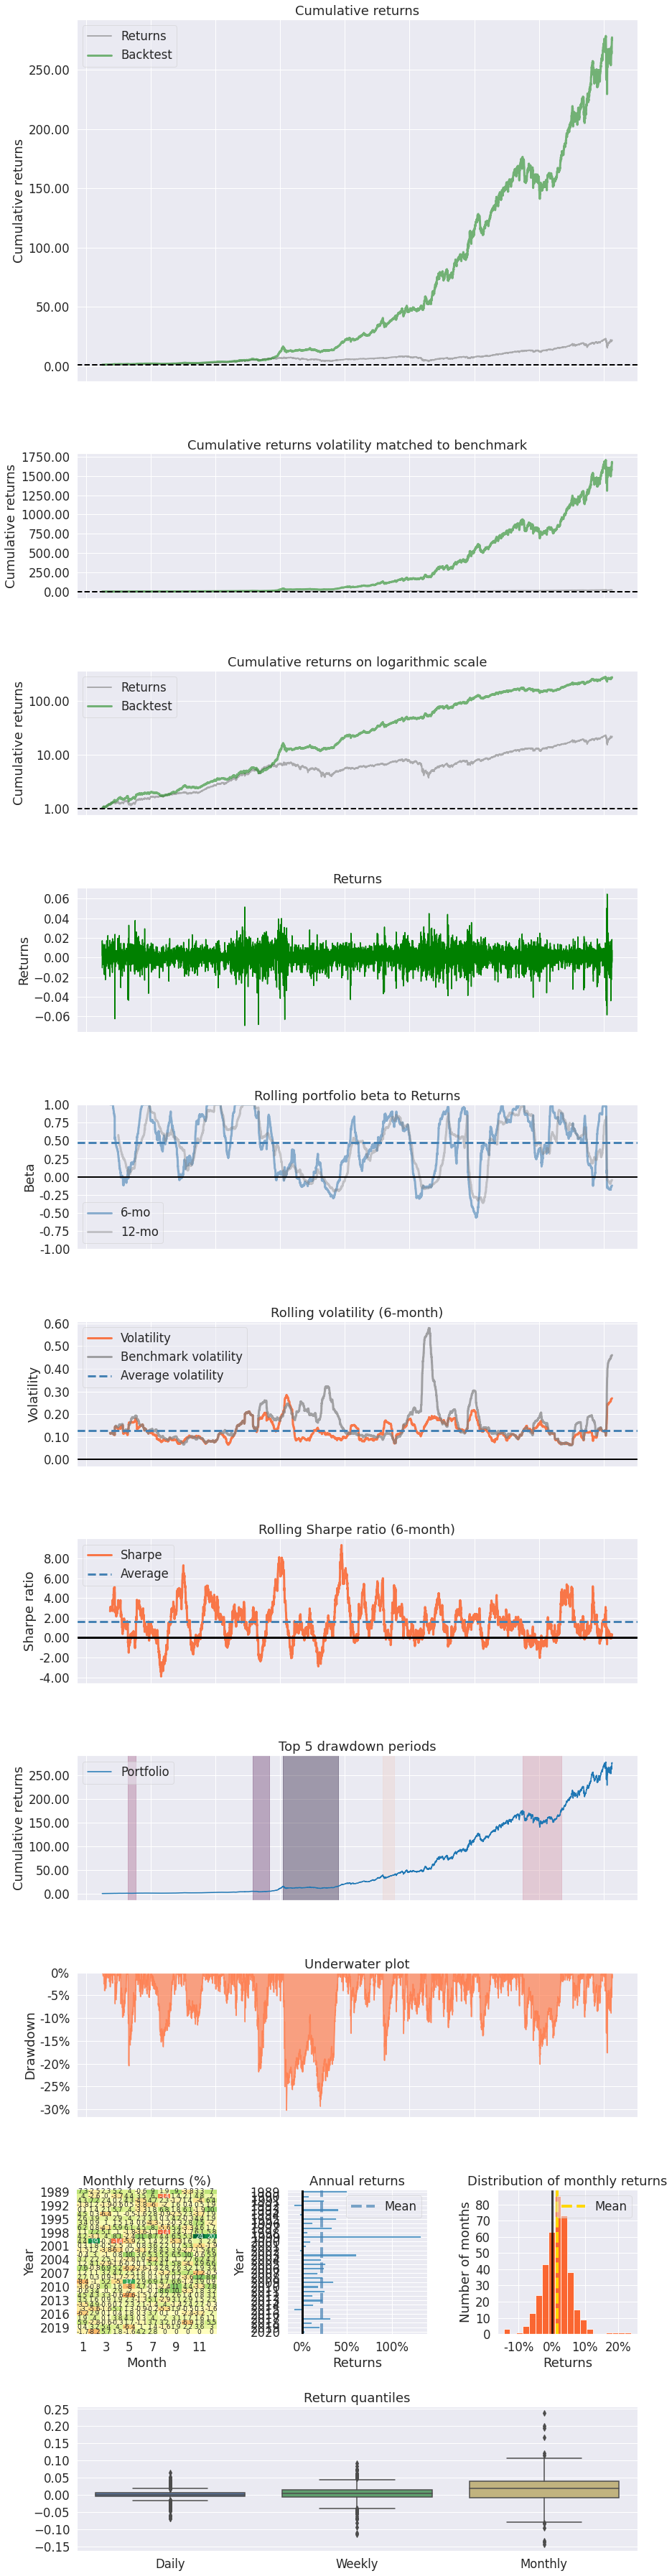

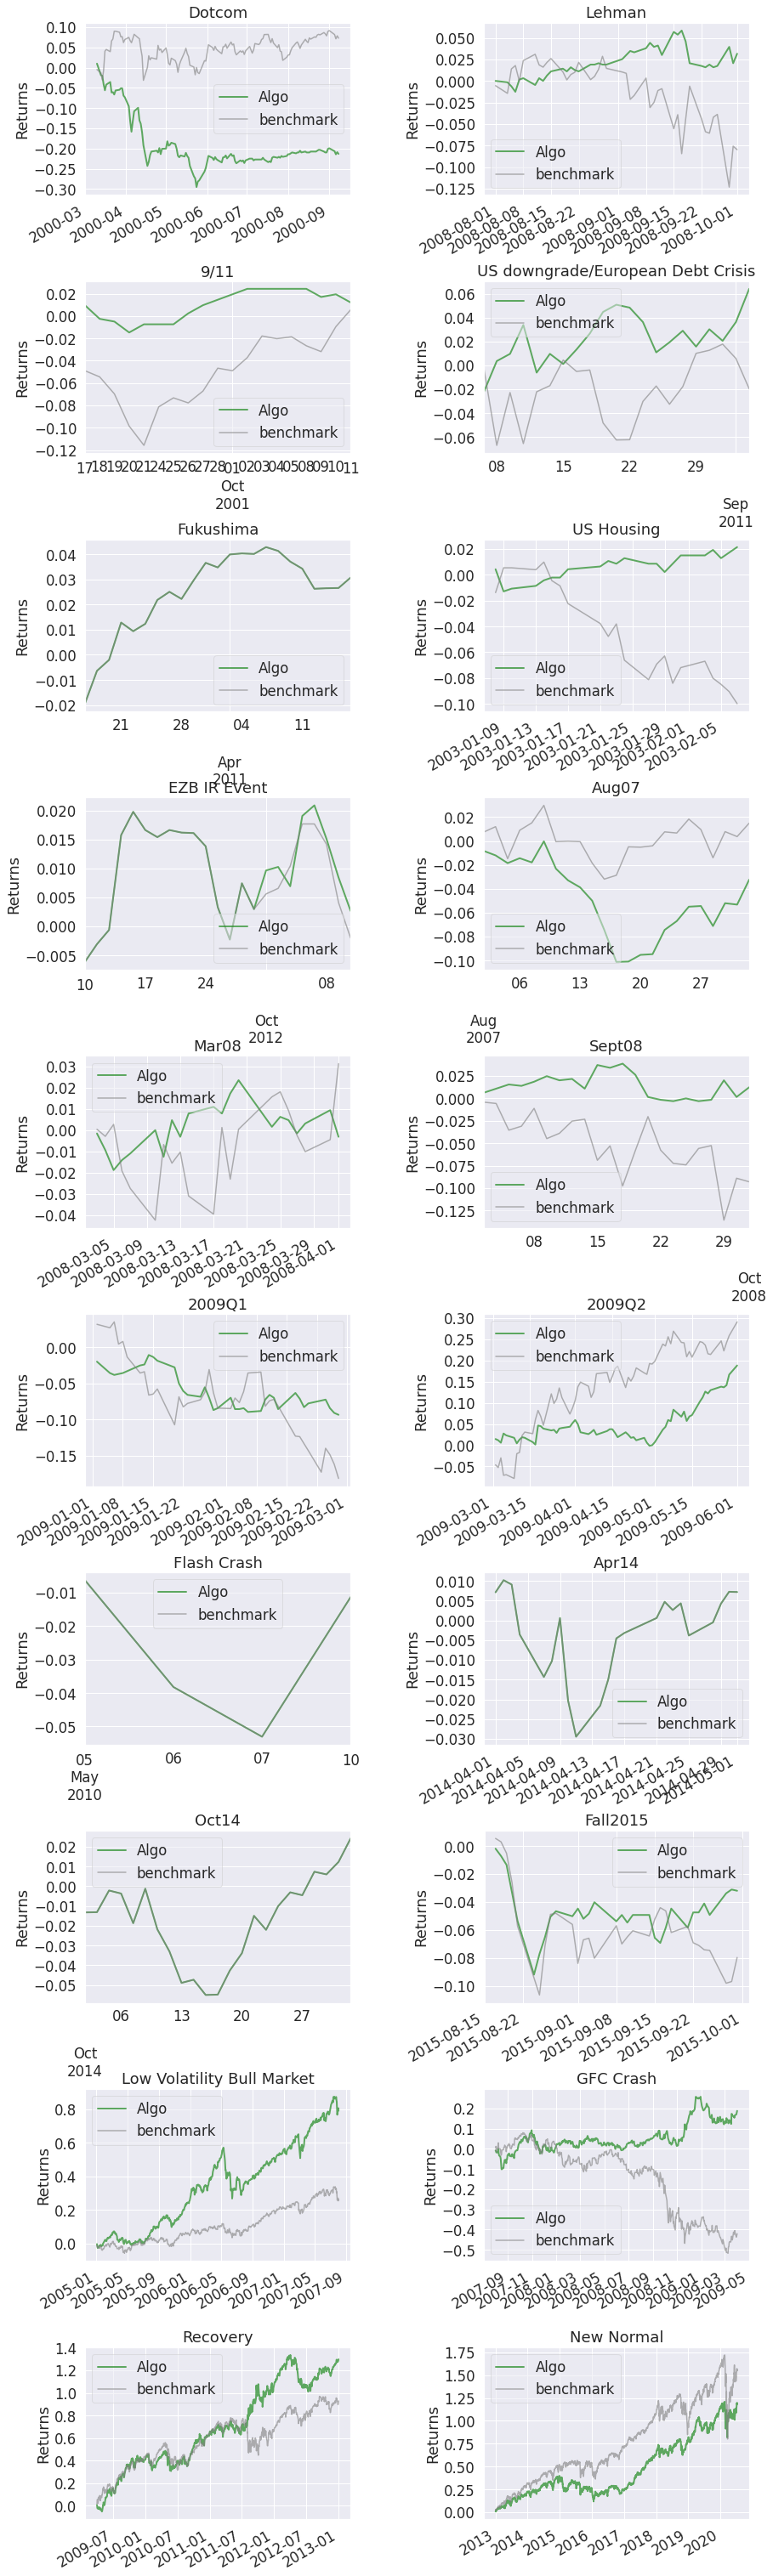

In [11]:
import pyfolio
pyfolio.create_full_tear_sheet(returns_df['Returns'], benchmark_rets=benchmark_aligned['Returns'])